In [1]:
# see https://huggingface.co/black-forest-labs/FLUX.1-schnell
# quantization code adapted from https://gist.github.com/AmericanPresidentJimmyCarter/873985638e1f3541ba8b00137e7dacd9

# if needed, install git-lfs (e.g., sudo apt-get install git-lfs)
!pip install optimum-quanto accelerate ipywidgets torch torchvision xformers --quiet -U
!pip install git+https://github.com/huggingface/diffusers.git --quiet

In [2]:
# if you have ~27GB+ VRAM (e.g., A100 on Colab), leave quantize as False for faster loading
# otherwise, for ~16GB VRAM compatibility, change to True (loading is VERY slow)

quantize = False # change to True for VRAM ~16GB (not recommended on Colab T4)

In [3]:
if quantize is False:
    import torch
    from diffusers import FluxPipeline
    
    pipe = FluxPipeline.from_pretrained('black-forest-labs/FLUX.1-schnell', 
                                        torch_dtype = torch.bfloat16)
    pipe.enable_model_cpu_offload() # save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power
    
    generator = torch.Generator().manual_seed(1234)

/home/daved/miniforge3/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/daved/miniforge3/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
if quantize is True:
    import torch
    from optimum.quanto import freeze, qfloat8, quantize
    from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
    from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
    from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
    from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast
    
    dtype = torch.bfloat16
    bfl_repo = 'black-forest-labs/FLUX.1-schnell'
    revision = 'refs/pr/1'
    
    scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder = 'scheduler', revision = revision)
    text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', torch_dtype = dtype)
    tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype = dtype)
    text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder = 'text_encoder_2', torch_dtype = dtype, revision = revision)
    tokenizer_2 = T5TokenizerFast.from_pretrained(bfl_repo, subfolder = 'tokenizer_2', torch_dtype = dtype, revision = revision)
    vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder = 'vae', torch_dtype = dtype, revision = revision)
    transformer = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder = 'transformer', torch_dtype = dtype, revision = revision)
    
    quantize(transformer, weights = qfloat8)
    freeze(transformer)
    
    quantize(text_encoder_2, weights = qfloat8)
    freeze(text_encoder_2)
    
    pipe = FluxPipeline(
        scheduler = scheduler,
        text_encoder = text_encoder,
        tokenizer = tokenizer,
        text_encoder_2 = None,
        tokenizer_2 = tokenizer_2,
        vae = vae,
        transformer = None,
    )
    
    pipe.text_encoder_2 = text_encoder_2
    pipe.transformer = transformer
    pipe.enable_model_cpu_offload()
    
    generator = torch.Generator().manual_seed(1234)

In [5]:
prompt = 'An MBA class learning about AI and deep learning'

  0%|          | 0/4 [00:00<?, ?it/s]

txt_ids.shape=torch.Size([1, 256, 3]), img_ids.shape=torch.Size([1, 4096, 3])
txt_ids.shape=torch.Size([1, 256, 3]), img_ids.shape=torch.Size([1, 4096, 3])
txt_ids.shape=torch.Size([1, 256, 3]), img_ids.shape=torch.Size([1, 4096, 3])
txt_ids.shape=torch.Size([1, 256, 3]), img_ids.shape=torch.Size([1, 4096, 3])


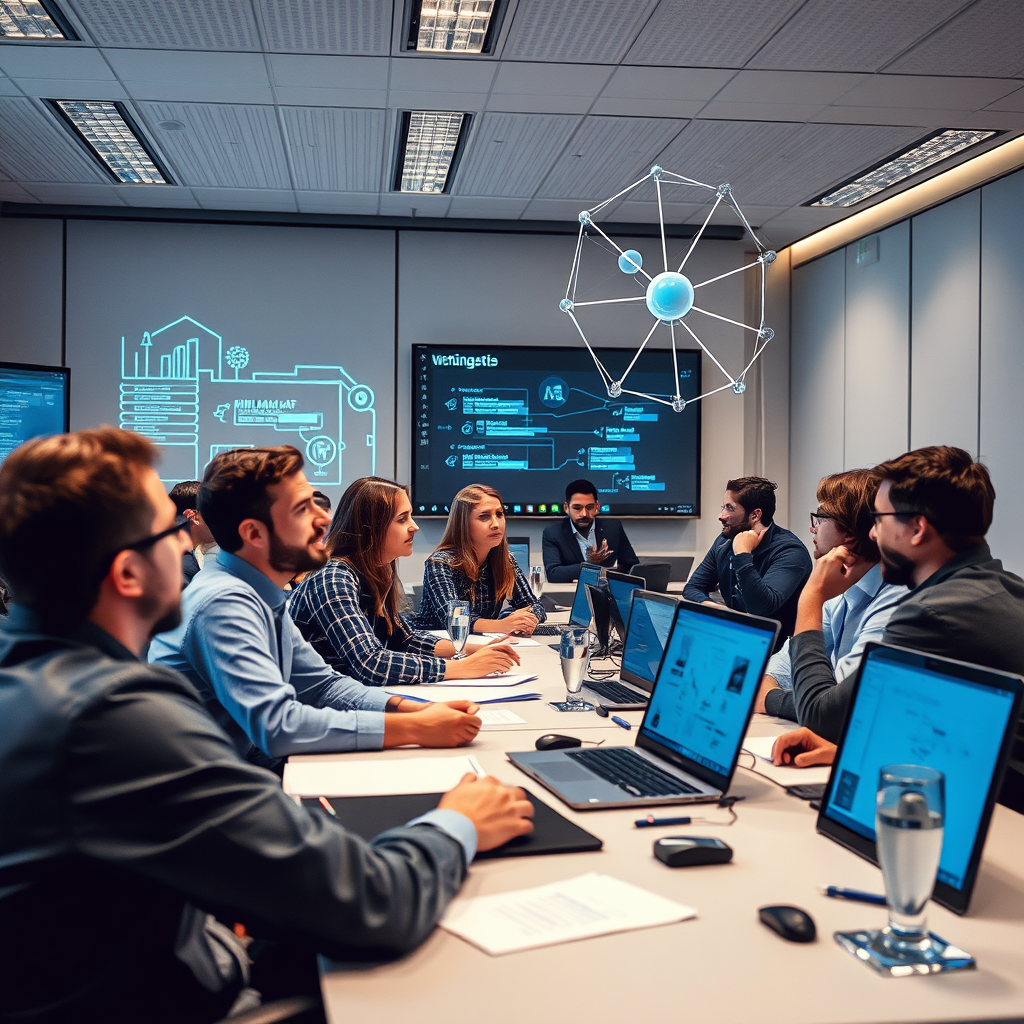

In [6]:
image = pipe(
    prompt = prompt, 
    output_type = 'pil',
    width = 1024,
    height = 1024,
    num_inference_steps = 4, 
    generator = generator,
    max_sequence_length = 256,
    guidance_scale = 3.5,
).images[0]

display(image)